Read SPRUCE data

In [4]:
## Read environment data
import pandas as pd
import glob
import os

# Define the base directory where your data is stored
base_dir = "../data/spruce_data/WEW_Complete_Environ_20240328"

# Find all CSV files matching the pattern
file_paths = glob.glob(os.path.join(base_dir, "*Complete_Environ_20240328.csv"))
# print(file_paths)
# Initialize a list to store DataFrames
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path, comment='#')
    # Keep only the relevant columns
    df = df[['TIMESTAMP', 'TA_2_0__1', 'Plot', 'Temp_target', 'CO2_trmt']]
    dfs.append(df)

# Combine all files into one DataFrame
data = pd.concat(dfs, ignore_index=True)
# print(data)
# ---------------------------
# First, try the original conversion (without infer_datetime_format)
data['timestamp'] = pd.to_datetime(data['TIMESTAMP'].str.strip(), errors='coerce')

# If there are any NaT values, use the fallback method for those rows
mask = data['timestamp'].isna()
if mask.any():
    # Keep the original timestamp string (if not already stripped)
    data.loc[mask, 'timestamp_str'] = data.loc[mask, 'TIMESTAMP'].str.strip()
    # Extract the expected datetime pattern from the string.
    # This pattern assumes the timestamp is in the format "YYYY-MM-DD HH:MM:SS"
    data.loc[mask, 'timestamp_extracted'] = data.loc[mask, 'timestamp_str'].str.extract(
        r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', expand=False
    )
    # Convert the extracted string into a datetime object.
    data.loc[mask, 'timestamp'] = pd.to_datetime(data.loc[mask, 'timestamp_extracted'], errors='coerce')

# Extract the year from the unified timestamp column
data['year'] = data['timestamp'].dt.year
# print(data['year'])
# print(data['timestamp'])
# ---------------------------
# Drop rows with missing temperature or timestamp
data_clean = data.dropna(subset=['timestamp', 'TA_2_0__1'])

# Group by year and Plot, compute annual average temperature
df_annual = data_clean.groupby(['year', 'Plot'])['TA_2_0__1'].mean().reset_index()
df_annual.rename(columns={'TA_2_0__1': 'annual_temp'}, inplace=True)
# print(df_annual)
# Pivot annual_temp
pivot_df = df_annual.pivot(index="Plot", columns="year", values="annual_temp")

# Rename columns to include variable name and year
pivot_df.columns = [f"annual_temp_{int(year)}" for year in pivot_df.columns]

# Reset index to bring 'Plot' back as a column and rename to lowercase 'plot'
df_envir = pivot_df.reset_index()
df_envir.rename(columns={'Plot': 'plot'}, inplace=True)

# # Print final columns to verify the presence of 2022 and 2023 (if available)
# print(df_envir.columns)


In [5]:
## Read ORNL PhenoCam data 25% rising and falling
import pandas as pd
import numpy as np

## ORNL PhenoCam data
df = pd.read_csv("../data/spruce_data/ORNL_PhenoCam/Phenology_TransitionDates_3day_2015_2023.csv")

# Create SOS dataframe for 'rising' direction
sos_df = df[df['direction'] == 'rising'].pivot_table(
    index=['veg_type', 'plot'], 
    columns='year', 
    values='transition_doy'
)
# Rename columns to include the prefix "sos_"
sos_df.columns = ['sos_' + str(col) for col in sos_df.columns]
sos_df = sos_df.reset_index()

# Create EOS dataframe for 'falling' direction
eos_df = df[df['direction'] == 'falling'].pivot_table(
    index=['veg_type', 'plot'], 
    columns='year', 
    values='transition_doy'
)
# Rename columns to include the prefix "eos_"
eos_df.columns = ['eos_' + str(col) for col in eos_df.columns]
eos_df = eos_df.reset_index()

# Merge the two dataframes on veg_type and plot
result_df = pd.merge(sos_df, eos_df, on=['veg_type', 'plot'], how='outer')

## Only to generate table for model
df = result_df.merge(df_envir, on="plot", how="inner")

df_pheno = result_df

df_pheno = df_pheno.merge(df_envir, on="plot", how="inner")
elevated_plots = [4, 10, 11, 16, 19]
df_pheno['co2_level'] = np.where(df_pheno['plot'].isin(elevated_plots), 'elevated', 'ambient')
df_pheno = df_pheno[df_pheno["co2_level"] == "elevated"] ######################################### Select ambient or elevated plots

eos_cols = df_pheno.loc[:, df_pheno.columns.str.contains('eos')]


Plot Fig. S9a

110


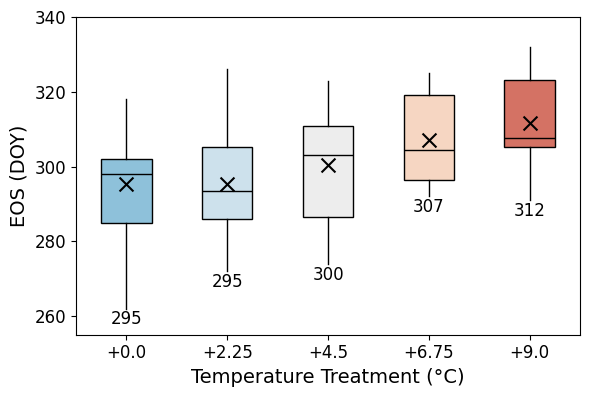

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Drop eos_2015 column if it exists
df_pheno = df_pheno.drop(columns=["eos_2015"], errors='ignore')
# print(df_pheno)
# Only keep one-year data
# df_pheno = df_pheno.drop(
#     columns=[
#         "eos_2016",
#         "eos_2017",
#         "eos_2018",
#         "eos_2019", 
#         "eos_2020", 
#         "eos_2021", 
#         "eos_2022",
#         # "eos_2023",
#     ],
#     errors='ignore'
# )


# Define temperature mapping from the image
temp_mapping = {
    2: "Ambient",
    4: "+4.5",
    5: "Ambient",
    6: "Control",
    7: "Ambient",
    8: "+6.75",
    9: "Ambient",
    10: "+9",
    11: "+2.25",
    13: "+4.5",
    14: "Ambient",
    15: "Ambient",
    16: "+6.75",
    17: "+9",
    19: "Control",
    20: "+2.25",
    21: "Ambient"
}

# Map plot to Temperature and numeric values
df_pheno["Temperature"] = df_pheno["plot"].map(temp_mapping)
temp_numeric_map = {
    "Control": 0,
    "+2.25": 2.25,
    "+4.5": 4.5,
    "+6.75": 6.75,
    "+9": 9
}
df_pheno["Temp_numeric"] = df_pheno["Temperature"].map(temp_numeric_map)
# print(df_pheno)

# Melt EOS columns into long format
eos_cols = [col for col in df_pheno.columns if col.startswith("eos_")]
df_long = df_pheno.melt(id_vars=["plot", "Temp_numeric"], value_vars=eos_cols,
                        var_name="Year", value_name="EOS")
# print(df_long)
# Drop missing EOS values
df_long = df_long.dropna()
# print(df_long)

# Group EOS by Temp_numeric to prepare data for boxplot
groups = df_long.groupby("Temp_numeric")["EOS"].apply(list).reset_index()

# Prepare boxplot data and positions
data = groups["EOS"].tolist()
positions = range(len(groups))  # integer positions for each box
# print(data)
## Count site-year
count = sum(len(inner_list) for inner_list in data)
print(count)

# Calculate mean EOS for each temperature group
means = groups["EOS"].apply(np.mean)

# Define gradient colors for the boxes
colors = ["#8ec1da", "#cde1ec", "#ededed", "#f6d6c2", "#d47264"]

# plt.figure(figsize=(6, 3))
plt.figure(figsize=(6, 4))

# Create the boxplot
bp = plt.boxplot(data, positions=positions, patch_artist=True,
                 medianprops=dict(color='black'),
                 capprops=dict(visible=False),
                 showfliers=False)

# Apply the gradient colors
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Plot mean values as black 'x' marks
plt.scatter(positions, means, color='black', marker='x', s=100, label='Mean', zorder=5)

# Annotate mean values just below the lower vertical whisker bar (vertical line)
for i, mean in enumerate(means):
    whisker = bp['whiskers'][2*i]  # lower whisker line for ith box
    xy = whisker.get_xydata()
    x = xy[0, 0]  # x coord of whisker line (vertical line so both points have same x)
    bottom_y = np.min(xy[:, 1])  # lowest y point of the whisker line

    plt.text(x, bottom_y - 0.5, f"{mean:.0f}", color='black',
             ha='center', va='top', fontsize=12)

# Set axis ticks and labels
# Format tick labels with "+" sign
tick_labels = [f"+{t}" for t in groups["Temp_numeric"]]
plt.xticks(positions, tick_labels, fontsize=12)
# plt.xticks(positions, groups["Temp_numeric"], fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Temperature Treatment (°C)", fontsize=14)
plt.ylabel("EOS (DOY)", fontsize=14)
plt.grid(False)
plt.tight_layout()

plt.ylim(255, 340)
plt.yticks([260, 280, 300, 320, 340])
plt.savefig("../results/si_figures/si_fig9/eos_elevated.png", dpi=300, bbox_inches='tight')
plt.show()


In [10]:
## Read environment data
import pandas as pd
import glob
import os

# Define the base directory where your data is stored
base_dir = "../data/spruce_data/WEW_Complete_Environ_20240328"

# Find all CSV files matching the pattern
file_paths = glob.glob(os.path.join(base_dir, "*Complete_Environ_20240328.csv"))
# print(file_paths)
# Initialize a list to store DataFrames
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path, comment='#')
    # Keep only the relevant columns
    df = df[['TIMESTAMP', 'TA_2_0__1', 'Plot', 'Temp_target', 'CO2_trmt']]
    dfs.append(df)

# Combine all files into one DataFrame
data = pd.concat(dfs, ignore_index=True)
# print(data)
# ---------------------------
# First, try the original conversion (without infer_datetime_format)
data['timestamp'] = pd.to_datetime(data['TIMESTAMP'].str.strip(), errors='coerce')

# If there are any NaT values, use the fallback method for those rows
mask = data['timestamp'].isna()
if mask.any():
    # Keep the original timestamp string (if not already stripped)
    data.loc[mask, 'timestamp_str'] = data.loc[mask, 'TIMESTAMP'].str.strip()
    # Extract the expected datetime pattern from the string.
    # This pattern assumes the timestamp is in the format "YYYY-MM-DD HH:MM:SS"
    data.loc[mask, 'timestamp_extracted'] = data.loc[mask, 'timestamp_str'].str.extract(
        r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', expand=False
    )
    # Convert the extracted string into a datetime object.
    data.loc[mask, 'timestamp'] = pd.to_datetime(data.loc[mask, 'timestamp_extracted'], errors='coerce')

# Extract the year from the unified timestamp column
data['year'] = data['timestamp'].dt.year
# print(data['year'])
# print(data['timestamp'])
# ---------------------------
# Drop rows with missing temperature or timestamp
data_clean = data.dropna(subset=['timestamp', 'TA_2_0__1'])

# Group by year and Plot, compute annual average temperature
df_annual = data_clean.groupby(['year', 'Plot'])['TA_2_0__1'].mean().reset_index()
df_annual.rename(columns={'TA_2_0__1': 'annual_temp'}, inplace=True)

# Pivot annual_temp
pivot_df = df_annual.pivot(index="Plot", columns="year", values="annual_temp")

# Rename columns to include variable name and year
pivot_df.columns = [f"annual_temp_{int(year)}" for year in pivot_df.columns]

# Reset index to bring 'Plot' back as a column and rename to lowercase 'plot'
df_envir = pivot_df.reset_index()
df_envir.rename(columns={'Plot': 'plot'}, inplace=True)

In [15]:
## Read ORNL PhenoCam data 25% rising and falling
import pandas as pd
import numpy as np

## ORNL PhenoCam data
df = pd.read_csv("../data/spruce_data/ORNL_PhenoCam/Phenology_TransitionDates_3day_2015_2023.csv")

# Create SOS dataframe for 'rising' direction
sos_df = df[df['direction'] == 'rising'].pivot_table(
    index=['veg_type', 'plot'], 
    columns='year', 
    values='transition_doy'
)
# Rename columns to include the prefix "sos_"
sos_df.columns = ['sos_' + str(col) for col in sos_df.columns]
sos_df = sos_df.reset_index()

# Create EOS dataframe for 'falling' direction
eos_df = df[df['direction'] == 'falling'].pivot_table(
    index=['veg_type', 'plot'], 
    columns='year', 
    values='transition_doy'
)
# Rename columns to include the prefix "eos_"
eos_df.columns = ['eos_' + str(col) for col in eos_df.columns]
eos_df = eos_df.reset_index()

# Merge the two dataframes on veg_type and plot
result_df = pd.merge(sos_df, eos_df, on=['veg_type', 'plot'], how='outer')

## Only to generate table for model
df = result_df.merge(df_envir, on="plot", how="inner")

## Change vegetation types here
veg_type = "EN"
# veg_type = "DN"
# veg_type = "SH"
df_pheno = result_df[result_df["veg_type"] == veg_type]

df_pheno = df_pheno.merge(df_envir, on="plot", how="inner")
elevated_plots = [4, 10, 11, 16, 19]
df_pheno['co2_level'] = np.where(df_pheno['plot'].isin(elevated_plots), 'elevated', 'ambient')
df_pheno = df_pheno[df_pheno["co2_level"] == "ambient"] ######################################### Select ambient or elevated plots

eos_cols = df_pheno.loc[:, df_pheno.columns.str.contains('eos')]

In [ ]:
Plot Fig. S9 (a,b,or c)

35


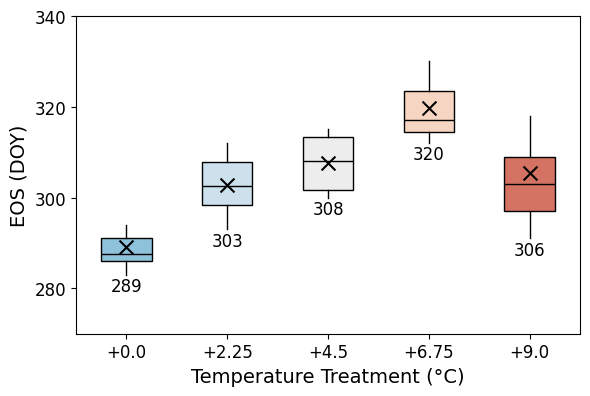

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Drop eos_2015 column if it exists
df_pheno = df_pheno.drop(columns=["eos_2015"], errors='ignore')

# Define temperature mapping from the image
temp_mapping = {
    2: "Ambient",
    4: "+4.5",
    5: "Ambient",
    6: "Control",
    7: "Ambient",
    8: "+6.75",
    9: "Ambient",
    10: "+9",
    11: "+2.25",
    13: "+4.5",
    14: "Ambient",
    15: "Ambient",
    16: "+6.75",
    17: "+9",
    19: "Control",
    20: "+2.25",
    21: "Ambient"
}

# Map plot to Temperature and numeric values
df_pheno["Temperature"] = df_pheno["plot"].map(temp_mapping)
temp_numeric_map = {
    "Control": 0,
    "+2.25": 2.25,
    "+4.5": 4.5,
    "+6.75": 6.75,
    "+9": 9
}
df_pheno["Temp_numeric"] = df_pheno["Temperature"].map(temp_numeric_map)
# print(df_pheno)

# Melt EOS columns into long format
eos_cols = [col for col in df_pheno.columns if col.startswith("eos_")]
df_long = df_pheno.melt(id_vars=["plot", "Temp_numeric"], value_vars=eos_cols,
                        var_name="Year", value_name="EOS")
# print(df_long)
# Drop missing EOS values
df_long = df_long.dropna()
# print(df_long)

# Group EOS by Temp_numeric to prepare data for boxplot
groups = df_long.groupby("Temp_numeric")["EOS"].apply(list).reset_index()

# Prepare boxplot data and positions
data = groups["EOS"].tolist()
positions = range(len(groups))  # integer positions for each box
# print(data)
## Count site-year
count = sum(len(inner_list) for inner_list in data)
print(count)

# Calculate mean EOS for each temperature group
means = groups["EOS"].apply(np.mean)

# Define gradient colors for the boxes
colors = ["#8ec1da", "#cde1ec", "#ededed", "#f6d6c2", "#d47264"]

# plt.figure(figsize=(6, 3))
plt.figure(figsize=(6, 4))

# Create the boxplot
bp = plt.boxplot(data, positions=positions, patch_artist=True,
                 medianprops=dict(color='black'),
                 capprops=dict(visible=False),
                 showfliers=False)

# Apply the gradient colors
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Plot mean values as black 'x' marks
plt.scatter(positions, means, color='black', marker='x', s=100, label='Mean', zorder=5)

# Annotate mean values just below the lower vertical whisker bar (vertical line)
for i, mean in enumerate(means):
    whisker = bp['whiskers'][2*i]  # lower whisker line for ith box
    xy = whisker.get_xydata()
    x = xy[0, 0]  # x coord of whisker line (vertical line so both points have same x)
    bottom_y = np.min(xy[:, 1])  # lowest y point of the whisker line

    plt.text(x, bottom_y - 0.5, f"{mean:.0f}", color='black',
             ha='center', va='top', fontsize=12)

# Set axis ticks and labels
# Format tick labels with "+" sign
tick_labels = [f"+{t}" for t in groups["Temp_numeric"]]
plt.xticks(positions, tick_labels, fontsize=12)
# plt.xticks(positions, groups["Temp_numeric"], fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Temperature Treatment (°C)", fontsize=14)
plt.ylabel("EOS (DOY)", fontsize=14)
plt.grid(False)
plt.tight_layout()

plt.ylim(270, 340)
plt.yticks([280, 300, 320, 340])
plt.savefig(f"../results/si_figures/si_fig9/eos_{veg_type}.png", dpi=300, bbox_inches='tight')

plt.show()
